# This script attempts to predict who will be bound

### Read in data from PostgreSQL

In [1588]:
from sqlalchemy import create_engine
import pandas as pd

postgres_url = ' some link :) '

engine = create_engine(postgres_url)

query = 'SELECT * \
         FROM insureds \
         LEFT JOIN households ON insureds.household_id = households.id \
         INNER JOIN properties ON properties.household_id = households.id \
         LEFT JOIN policies ON policies.property_id = properties.id \
         LEFT JOIN (SELECT DISTINCT ON (verisk_valuations.address_id) * \
         FROM verisk_valuations ORDER BY verisk_valuations.address_id, \
         verisk_valuations.updated_at DESC ) verisk_valuations \
         ON verisk_valuations.address_id = properties.address_id'

#
#         INNER JOIN verisk_valuations ON properties.id = verisk_valuations.property_id;'

df = pd.read_sql_query(query, con=engine)

#df.to_csv('/Users/mattelgazar/Desktop/Data/insureds_joined_data.csv')

### Query recent unseen data for recent predictions

In [1589]:
query_test = "SELECT * \
         FROM insureds \
         LEFT JOIN households ON insureds.household_id = households.id \
         INNER JOIN properties ON properties.household_id = households.id \
         LEFT JOIN policies ON policies.property_id = properties.id \
         LEFT JOIN (SELECT DISTINCT ON (verisk_valuations.address_id) * \
         FROM verisk_valuations ORDER BY verisk_valuations.address_id, \
         verisk_valuations.updated_at DESC ) verisk_valuations \
         ON verisk_valuations.address_id = properties.address_id \
         WHERE insureds.created_at >= (CURRENT_DATE - INTERVAL '1 day')::date"

df_test = pd.read_sql_query(query_test, con=engine)

In [1590]:
df.head()

,id,household_id,address_id,user_id,created_by_id,first_name,last_name,phone,email,dob,...,garage_style,pool_value,valuation_id,half_bathrooms,full_bathrooms,one_and_a_half_bathrooms,address_id,detached_structures_value,year_built,sq_ft
0,154,269710,NaN,471.0,None,Candace,Fender,+17724651432,None,1953-03-03,...,None,0.00,AA8Z-G8RJ,NaN,3.0,NaN,1566.0,42375.25,NaN,NaN
1,156,269715,NaN,473.0,None,Alex,Abrams,+14079213000,None,1947-11-23,...,Attached / Built-In,0.00,AA8Z-M9ZB,NaN,2.0,NaN,1574.0,.00,NaN,NaN
2,158,269735,NaN,482.0,None,WILLARDO,EMDEN,+13869867680,None,1981-04-18,...,Attached / Built-In,0.00,AA8Z-S9BZ,NaN,2.0,NaN,1601.0,.00,NaN,NaN
3,161,269763,NaN,497.0,None,Kishore,Adurty,+18055016143,None,1978-02-22,...,Attached / Built-In,0.00,AA9A-B9YR,NaN,1.0,NaN,1632.0,.00,NaN,NaN
4,163,269777,NaN,503.0,None,Dana,Johnson,+18507974026,None,1982-06-25,...,Attached / Built-In,0.00,AA9A-F9CD,NaN,1.0,NaN,1648.0,.00,NaN,NaN


In [1591]:
df['dob'].isnull().sum()

19

### Define a function that gets the age

In [1592]:
import datetime, dateutil

def get_age(date):
    # Get the current date
    now = datetime.datetime.utcnow()
    now = now.date()

    # Get the difference between the current date and dob
    age = dateutil.relativedelta.relativedelta(now, date)
    age = age.years

    return age

df['age'] = df.apply(lambda x: get_age(x['dob']), axis=1) # get the users age

In [1593]:
import datetime 

def get_year_month(field):
    year = field.year
    month = field.month
    return (year, month)

lst=[]
for i in df['dob']:
    try:
        if type(i) == datetime.date:
            lst.append(get_year_month(i))
        else:
            lst.append(i)
    except AttributeError:
        pass

df['dob'] = pd.Series(lst, index=df.index)

#get_year_month(df.dob[9172])
df['dob'].head()

0     (1953, 3)
1    (1947, 11)
2     (1981, 4)
3     (1978, 2)
4     (1982, 6)
Name: dob, dtype: object

In [1594]:
df.loc[df['last_name']=='Copening', 'age'] = df.age.median()
#df.loc[df.age < 0]
df.loc[df['last_name'] == 'Copening']

,id,household_id,address_id,user_id,created_by_id,first_name,last_name,phone,email,dob,...,pool_value,valuation_id,half_bathrooms,full_bathrooms,one_and_a_half_bathrooms,address_id,detached_structures_value,year_built,sq_ft,age
16213,12373,341676,67820.0,22721.0,None,Andrew,Copening,+17276673085,None,"(3085, 5)",...,0.00,AB5V-M9WP,1.0,1.0,1.0,67820.0,.00,NaN,NaN,55.0


In [1595]:
df.loc[df['last_name'] == 'Copening', 'dob'] = df.loc[df['last_name'] == 'Copening', 'dob'].apply(lambda x: get_year_month(pd.to_datetime('1963-01')))

df.loc[df['last_name'] == 'Copening']

,id,household_id,address_id,user_id,created_by_id,first_name,last_name,phone,email,dob,...,pool_value,valuation_id,half_bathrooms,full_bathrooms,one_and_a_half_bathrooms,address_id,detached_structures_value,year_built,sq_ft,age
16213,12373,341676,67820.0,22721.0,None,Andrew,Copening,+17276673085,None,"(1963, 1)",...,0.00,AB5V-M9WP,1.0,1.0,1.0,67820.0,.00,NaN,NaN,55.0


### Categorize age in groups of 10. Also Categorize date of birth (dob) by month and year

In [1596]:
lst=[]
for a in df.age:
    if a >= 0 and a < 10:
        lst.append(0)
    elif a >= 10 and a < 20:
        lst.append(1)
    elif a >= 20 and a < 30:
        lst.append(2)
    elif a >= 30 and a < 40:
        lst.append(3)
    elif a >= 40 and a < 50:
        lst.append(4)
    elif a >= 50 and a < 60:
        lst.append(5)
    elif a >= 60 and a < 70:
        lst.append(6)
    elif a >= 70 and a < 80:
        lst.append(7)
    elif a >= 80 and a < 90:
        lst.append(8)
    elif a >= 90 and a < 100:
        lst.append(9)
    elif a >= 100:
        lst.append(10)

df.age = pd.Series(lst, index=df.index)
df.age.value_counts()

5     5287
6     4835
4     3809
3     3279
7     2637
2     1230
8      846
9       88
1       30
10      29
0       26
Name: age, dtype: int64

In [1597]:
len(lst), len(df)

(22096, 22096)

### Group sale_price by the nearest 15K using the ceiling function

In [1598]:
import math

def roundup_15k(x):
    return float(math.ceil(x / 15000.0)) * 15000

df['sale_price'] = df['sale_price'].apply(lambda x: roundup_15k(x))
df['sale_price']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24            NaN
25            NaN
26            NaN
27            NaN
28            NaN
29            NaN
           ...   
22066     60000.0
22067    165000.0
22068    615000.0
22069     15000.0
22070    300000.0
22071     15000.0
22072    330000.0
22073    255000.0
22074    330000.0
22075    210000.0
22076     30000.0
22077     30000.0
22078         NaN
22079     60000.0
22080     30000.0
22081    135000.0
22082         NaN
22083    105000.0
22084    315000.0
22085     15000.0
22086    360000.0
22087     60000.0
22088         NaN
22089    210000.0
22090    2

### Group construction_year into 5 year increments and year_built into 10-year increments using the ceiling function

In [1599]:
def roundup_10(x):
    return float(math.ceil(x / 10.0)) * 10

#df['sale_price'] = df['sale_price'].apply(lambda x: roundup_15k(x))
df['year_built'] = df['year_built'].iloc[:, 0]
df['year_built']

df['year_built'] = df['year_built'].iloc[:, 0].apply(lambda row: roundup_10(row))
#len(df['year_built'].value_counts())

In [1600]:
def roundup_5(x):
    return float(math.ceil(x / 5.0)) * 5


lst=[]
for i in df['construction_year']:
    try:
        lst.append(roundup_5(int(i)))
    except TypeError:
        lst.append(-1)
    
df['construction_year'] = pd.Series(lst, index=df.index)
df['construction_year']

0        1945.0
1        1980.0
2        1995.0
3        2015.0
4        1980.0
5        1960.0
6        1980.0
7        1980.0
8        1980.0
9        1980.0
10       2020.0
11       1980.0
12       1965.0
13       1975.0
14       1975.0
15       1985.0
16       1930.0
17       1995.0
18       1965.0
19       1980.0
20       2010.0
21       1995.0
22       1990.0
23       1980.0
24       2020.0
25       2005.0
26       1990.0
27       1965.0
28       2010.0
29       2010.0
          ...  
22066    1985.0
22067    1980.0
22068    2000.0
22069    2005.0
22070    2020.0
22071    1970.0
22072    1975.0
22073    1955.0
22074    2005.0
22075    2005.0
22076    1990.0
22077    1970.0
22078    1960.0
22079    1940.0
22080    1955.0
22081    2000.0
22082    1995.0
22083    1980.0
22084    2020.0
22085    1950.0
22086    1985.0
22087    1975.0
22088    1960.0
22089    1990.0
22090    1995.0
22091    1985.0
22092    1980.0
22093    1990.0
22094    1960.0
22095    1975.0
Name: construction_year,

In [1601]:
df['created_at'].head()

,created_at,created_at,created_at,created_at,created_at
0,2017-06-01 19:11:05.353477,2017-06-01 19:02:22.628143,2017-06-01 19:02:22.929275,NaT,2017-06-01 19:02:24.725167
1,2017-06-02 11:25:10.435432,2017-06-02 11:22:52.782917,2017-06-02 11:22:53.166041,NaT,2017-06-02 11:22:55.223832
2,2017-06-02 18:09:05.369519,2017-06-02 18:07:13.228093,2017-06-02 18:07:13.730634,NaT,2017-06-02 18:07:16.071248
3,2017-06-05 14:18:04.850484,2017-06-05 14:15:15.701160,2017-06-05 14:15:15.922421,NaT,2017-06-05 14:15:17.281972
4,2017-06-05 18:19:52.293784,2017-06-05 18:13:38.419674,2017-06-05 18:13:38.799695,NaT,2017-06-05 18:13:40.636521


### Find columns with duplicate column names

In [1602]:
import collections
duplicate_cols = [item for item, count in collections.Counter(list(df.columns)).items() if count > 1]
print duplicate_cols

[u'property_id', u'usage', u'replacement_cost', u'household_id', u'created_by_id', u'exterior_wall_finish_code', u'address_id', u'stories', u'sq_ft', u'updated_at', u'id', u'status', u'freshsales_id', u'year_built', u'residence_type', u'created_at']


In [1603]:
print len(duplicate_cols)

16


### Rename duplicate column names based on the database they come from

In [1604]:
df['created_at'].tail()

,created_at,created_at,created_at,created_at,created_at
22091,2018-03-06 14:52:32.410688,2018-03-06 14:37:07.269155,2018-03-06 14:37:07.456510,NaT,2018-03-06 14:37:09.290427
22092,2018-03-06 15:32:52.373336,2018-03-06 15:29:32.952919,2018-03-06 15:29:33.319099,NaT,2018-03-06 15:29:34.927620
22093,2018-03-06 16:09:22.704392,2018-03-06 16:05:12.434952,2018-03-06 16:05:12.790236,NaT,2018-03-06 16:05:14.282723
22094,2018-03-06 18:50:20.166035,2018-03-06 18:45:20.472722,2018-03-06 18:45:21.059717,2018-03-12 17:24:35.877165,2018-03-06 18:45:22.383600
22095,2018-03-07 01:32:18.715401,2018-03-06 15:36:26.501682,2018-03-06 15:36:26.622034,NaT,2018-03-06 15:36:27.978723


### Merge df['year_built'] with each other because some id's have values and some don't. Fill nan values with -1 because that value will not exist in this column

In [1605]:
df['year_built'] = df['year_built'].iloc[:, 0].fillna(-1) + df['year_built'].iloc[:, 1].fillna(-1)

In [1606]:
df['year_built'].isnull().sum()

year_built    0
year_built    0
dtype: int64

### Replace duplicate column names to what table each column came from

In [1607]:
col_name = {'created_at' : ['created_at_insureds', 'created_at_households', 
                         'created_at_properties', 'created_at_verisk', 'created_at_policies'], 
            'id' : ['id_insureds', 'id_households', 'id_properties', 'id_verisk', 'id_policies'],
            'address_id' : ['address_id_to_drop', 'address_id', 'address_id_drop2'],
            'created_by_id' : ['created_by_id_drop1', 'created_by_id_drop2'],
            'updated_at' : ['updated_at_insureds', 'updated_at_households', 
                            'updated_at_properties', 'updated_at_verisk', 'updated_at_policies'],
            'household_id' : ['household_id', 'household_id_to_drop',
                              'household_id_properties', 'household_id_policies'],
            'status' : ['status', 'status_to_drop'],
            'sq_ft' : ['sq_ft_to_drop', 'sq_ft'],
            'year_built' : ['year_built', 'year_built_to_drop'],
            'stories' : ['stories_to_drop', 'stories'],
            'exterior_wall_finish_code' : ['exterior_wall_finish_code_to_drop', 'exterior_wall_finish_code'],
            'replacement_cost' : ['replacement_cost', 'replacement_cost_to_drop'],
            'usage' : ['usage', 'usage_to_drop']}

df = df.rename(columns=lambda col: col_name[col].pop(0) if col in col_name.keys() else col)
#print col_name.keys()

In [1608]:
df.year_built.isnull().sum()

0

In [1609]:
df.last_name.isnull().sum()

19

In [1610]:
print len(df.columns), ' columns'
print len(df['created_at_insureds']), ' rows'

131  columns
22096  rows


In [1611]:
df.last_name.isnull().sum()

19

###### Drop duplicate columns in dataframe -> Should reduce from 130 to 126 features

In [1612]:
import numpy as np

print 'Originally there were ', len(df.columns)
_, i = np.unique(df.columns, return_index=True)
print 'Now there are ', len(np.unique(df.columns)), ' columns'
#len(df.iloc[:, i].columns), ' columns'

Originally there were  131
Now there are  127  columns


In [1613]:
df.last_name.isnull().sum()

19

In [1614]:
df.bound_at = df.bound_at.fillna(0) # fill NaT values with 0
df.bound_at.tail(10)

22086                      0
22087                      0
22088                      0
22089                      0
22090                      0
22091                      0
22092                      0
22093                      0
22094    2018-03-12 05:00:00
22095                      0
Name: bound_at, dtype: object

In [1615]:
df.last_name.isnull().sum()

19

In [1616]:
bound_at_lst = list(df.bound_at) # Make sure you only run this cell once!

In [1617]:
df.last_name.isnull().sum()

19

In [1618]:
#df.bound_at.replace(1, type(df.bound_at) == pd._libs.tslib.Timestamp) # Replace timestamp values with 1

lst=[]

for target in bound_at_lst:
    if target != 0:
        lst.append(1)
    else:
        lst.append(0)

    
df['bound_at'] = pd.Series(lst, index=df.bound_at.index)

df.bound_at.tail(20)

22076    0
22077    0
22078    0
22079    0
22080    0
22081    1
22082    0
22083    0
22084    0
22085    0
22086    0
22087    0
22088    0
22089    0
22090    0
22091    0
22092    0
22093    0
22094    1
22095    0
Name: bound_at, dtype: int64

In [1619]:
df.last_name.isnull().sum()

19

In [1620]:
df['bound_at'].tail(10)

22086    0
22087    0
22088    0
22089    0
22090    0
22091    0
22092    0
22093    0
22094    1
22095    0
Name: bound_at, dtype: int64

In [1621]:
df.bound_at.isnull().sum()

0

In [1622]:
df['area_code'] = df.phone.str.lstrip('+1').str[:3] # get the area code instead of keeping the whole phone number
df.drop(['property_record', 'attributes_at_create', 
         'sq_ft_to_drop', 'year_built_to_drop',
         'exterior_wall_finish_code_to_drop', 'replacement_cost_to_drop',
         'address_id_to_drop', 'address_id_to_drop2',
         'created_by_id_drop', 'created_by_id_drop2',
         'household_id_to_drop'],
         axis=1, inplace=True) # Drop this column first because it is out-dated



In [1623]:
df.loc[df.age < 0]

,id_insureds,household_id,user_id,created_by_id_drop1,first_name,last_name,phone,email,dob,co_applicant,...,pool_value,valuation_id,half_bathrooms,full_bathrooms,one_and_a_half_bathrooms,address_id_drop2,detached_structures_value,sq_ft,age,area_code


##### Set age to Andrew Copening to average age and change his dob because there is a mistake in the data

In [1624]:
len(df.age), len(lst)
df.loc[df.age < 0]

,id_insureds,household_id,user_id,created_by_id_drop1,first_name,last_name,phone,email,dob,co_applicant,...,pool_value,valuation_id,half_bathrooms,full_bathrooms,one_and_a_half_bathrooms,address_id_drop2,detached_structures_value,sq_ft,age,area_code


### Drop obvious unimportant and unpredictable features first

In [1625]:
df.drop(['cancellation_date',
        'cancellation_reason_id',
        'filing_id',
        'phone',
        'midterm_endorsement',
        'declaration_effective_date',
        'issued_at',
        'rental_to_others',
        'years_at_residence',
        'months_unoccupied',
        'number_of_families',
        'foundation_type_id',
        'bedrooms',
        'sq_ft',
        'construction_type_id',
        'first_name',
        'residence_type',
        'freshsales_id',
        'deleted_at',
        'billing_method_id',
        'id_verisk',
        'start_date',
        'end_date',
        'property_id',
        'created_at_verisk',
        'updated_at_verisk',
        'policy_number_id',
        'effective_date',
        'address_id_drop2',
        'property_record',
        'created_by_id_drop1',
        'status_to_drop',
        'bound_by_id',
        'sale_date',
        'stories_to_drop',
        'usage_to_drop',
        'bound_premium',
        'address_id',
        'ncf_id',
        'payment_plan',
        'id_properties',
        'id_policies',
        'id_households',
        'household_id',
        'external_id',
        'valuation_id',
        'user_id',
        'prior_liability_limit',
        'pas_enabled',
        'id_insureds',
        'created_at_policies',
        'remember_token',
        'updated_at_policies',
        'last_name'],
         axis=1, inplace=True)
len(df.columns)

66

### Find numeric and non-numeric columns and can convert non-numerical columns to categorical data

In [1626]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

print 'There are ', len(df.select_dtypes(include=numerics).T), 'numeric columns and \
', len(df.columns)-len(df.select_dtypes(include=numerics).T), ' non-numeric columns'

There are  24 numeric columns and  42  non-numeric columns


### Convert non-numeric features to categorical features

In [1627]:
for field_name, dtype in df.dtypes[df.dtypes == 'object'].items():
    print(field_name)
    df[field_name] = pd.Series(pd.Categorical(df[field_name]).codes)
    
#for feature in df.columns: # Loop through all columns in the dataframe
#    if df[feature].dtype == 'object': # Only apply for columns with categorical strings
#        df[feature] = pd.Categorical(df[feature]).codes # Replace strings with an integer

email
dob
married
property_type
foundation
roof_shape
protection_class
roof_type
construction_type
status
burglar_alarm
fire_alarm_sprinkler
fire_alarm_monitoring
secured_community
water_detection
builder
usage
children_present
pool
underwriting_confirmed
success
roof_cover_code
units_in_building
roof_shape_code
exterior_wall_construction_code
exterior_wall_finish_code
foundation_type_code
garage_cars
garage_style
pool_value
detached_structures_value
area_code


In [1628]:
len(df.select_dtypes(include=[np.number]).columns.tolist())

56

In [1629]:
print (df.dtypes[df.dtypes == 'object'])

# Annnnddd... now every column has no string datatypes... :) 

Series([], dtype: object)


### Fill NaN values with reasonable values depending on each column

##### Find all columns that contain NaN values

In [1630]:
df.isna().any() # shows True or False if it contains NaN values

print 'There are ', len(df.isna().any()[df.isna().any() == True].index), ' columns that have NaN values'

df.isna().any()[df.isna().any() == True].index

There are  16  columns that have NaN values


Index([            u'liability_claim_count',
       u'non_liability_non_cat_claim_count',
                     u'remember_created_at',
                              u'sale_price',
                               u'bathrooms',
                                u'roof_age',
                        u'replacement_cost',
              u'renovation_year_electrical',
                u'renovation_year_plumbing',
            u'renovation_year_water_heater',
                 u'renovation_year_heating',
                                 u'stories',
                   u'foundation_percentage',
                          u'half_bathrooms',
                          u'full_bathrooms',
                u'one_and_a_half_bathrooms'],
      dtype='object')

In [1631]:
df['liability_claim_count'].isnull().sum()
df['non_liability_non_cat_claim_count'].isnull().sum()
df['remember_created_at'].isnull().sum()
df['sale_price'].isnull().sum()
df['bathrooms'].isnull().sum()
df['roof_age'].isnull().sum()
df['replacement_cost'].isnull().sum()
df['renovation_year_electrical'].isnull().sum()
df['renovation_year_plumbing'].isnull().sum()
df['renovation_year_water_heater'].isnull().sum()
df['renovation_year_heating'].isnull().sum()
df['stories'].value_counts()
df['foundation_percentage'].value_counts()
df['half_bathrooms'].value_counts()
df['full_bathrooms'].value_counts()
df['one_and_a_half_bathrooms'].isnull().sum()

21222

In [1632]:
df['one_and_a_half_bathrooms'].loc[df['one_and_a_half_bathrooms']==0]

Series([], Name: one_and_a_half_bathrooms, dtype: float64)

In [1633]:
df['liability_claim_count'] = df['liability_claim_count'].fillna(-1)
df['non_liability_non_cat_claim_count'] = df['non_liability_non_cat_claim_count'].fillna(-1)
df['remember_created_at'] = df['remember_created_at'].fillna(-1)
df['sale_price'] = df['sale_price'].fillna(-1)
df['bathrooms'] = df['bathrooms'].fillna(-1)
df['roof_age'] = df['roof_age'].fillna(-1)
df['replacement_cost'] = df['replacement_cost'].fillna(df['replacement_cost'].mean()) # fill with mean
df['renovation_year_electrical'] = df['renovation_year_electrical'].fillna(-1) # -1 means they never had a renovation
df['renovation_year_plumbing'] = df['renovation_year_plumbing'].fillna(-1)
df['renovation_year_water_heater'] = df['renovation_year_water_heater'].fillna(-1)
df['renovation_year_heating'] = df['renovation_year_heating'].fillna(-1)
df['stories'] = df['stories'].fillna(1) # fill with the majority class by a lot
df['foundation_percentage'] = df['foundation_percentage'].fillna(100) # majority class by a lot
df['half_bathrooms'] = df['half_bathrooms'].fillna(-1) # -1 means we don't know
df['full_bathrooms'] = df['full_bathrooms'].fillna(2) # majority class
df['one_and_a_half_bathrooms'] = df['one_and_a_half_bathrooms'].fillna(-1) # -1 means we don't know

In [1634]:
# All of these outputs should be 0 -> i.e. have no null values
print df['liability_claim_count'].isnull().sum()
print df['non_liability_non_cat_claim_count'].isnull().sum()
print df['remember_created_at'].isnull().sum()
print df['sale_price'].isnull().sum()
print df['bathrooms'].isnull().sum()
print df['roof_age'].isnull().sum()
print df['replacement_cost'].isnull().sum()
print df['renovation_year_electrical'].isnull().sum()
print df['renovation_year_plumbing'].isnull().sum()
print df['renovation_year_water_heater'].isnull().sum()
print df['renovation_year_heating'].isnull().sum()
print df['stories'].isnull().sum()
print df['foundation_percentage'].isnull().sum()
print df['half_bathrooms'].isnull().sum()
print df['full_bathrooms'].isnull().sum()
print df['one_and_a_half_bathrooms'].isnull().sum()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


### Convert the datetime cells to numeric cells

In [1635]:
categories= ['object', 'datetime64', 'datetime', 'timedelta', 'timedelta64', 'category', 'datetimetz']
df.select_dtypes(include=categories)
df.select_dtypes(include=categories).columns

Index([  u'created_at_insureds',   u'updated_at_insureds',
       u'created_at_households', u'updated_at_households',
         u'remember_created_at', u'created_at_properties',
       u'updated_at_properties'],
      dtype='object')

In [1636]:
categories= ['object', 'datetime64', 'datetime', 'timedelta', 'timedelta64', 'category', 'datetimetz']

# Loop through all columns in the dataframe that have dtype=categories
for feature in df.select_dtypes(include=categories).columns:
    try:
        df[feature] = pd.to_datetime(df[feature]) # Convert datetime string columns to datetime object columns
    except ValueError: # Except ValueError because df['remember_created_at'] has mixed datatypes since I filled NaN values with -1 
        df[feature]

df.select_dtypes(include=categories).head(10)

,created_at_insureds,updated_at_insureds,created_at_households,updated_at_households,remember_created_at,created_at_properties,updated_at_properties
0,2017-06-01 19:11:05.353477,2017-06-01 19:11:05.353477,2017-06-01 19:02:22.628143,2017-06-01 19:02:22.675266,2017-06-01 19:02:22.673601,2017-06-01 19:02:22.929275,2017-12-19 19:40:55.227872
1,2017-06-02 11:25:10.435432,2017-06-02 11:25:10.435432,2017-06-02 11:22:52.782917,2017-06-02 11:22:52.826031,2017-06-02 11:22:52.824468,2017-06-02 11:22:53.166041,2017-12-15 18:57:59.187345
2,2017-06-02 18:09:05.369519,2017-06-02 18:09:05.369519,2017-06-02 18:07:13.228093,2017-06-02 18:07:13.286320,2017-06-02 18:07:13.283250,2017-06-02 18:07:13.730634,2017-12-19 19:40:55.519159
3,2017-06-05 14:18:04.850484,2017-06-05 14:18:04.850484,2017-06-05 14:15:15.701160,2017-06-05 14:15:15.745619,2017-06-05 14:15:15.744237,2017-06-05 14:15:15.922421,2017-12-19 19:40:55.999307
4,2017-06-05 18:19:52.293784,2017-06-05 18:19:52.293784,2017-06-05 18:13:38.419674,2017-06-05 18:13:38.464183,2017-06-05 18:13:38.462515,2017-06-05 18:13:38.799695,2017-12-19 19:40:56.133075
5,2017-06-05 23:28:41.243767,2017-06-05 23:28:41.243767,2017-06-05 22:45:44.991487,2017-06-05 22:50:49.155561,2017-06-05 22:50:49.153701,2017-06-05 22:45:45.261975,2017-12-19 19:40:56.347447
6,2017-06-06 12:26:57.590610,2017-06-06 12:26:57.590610,2017-06-05 21:49:10.414329,2017-06-06 12:13:05.220885,2017-06-06 12:13:05.218922,2017-06-05 21:49:10.620681,2017-12-19 19:40:56.314880
7,2017-06-06 19:05:50.459851,2017-06-06 19:05:50.459851,2017-06-06 19:03:26.998096,2017-06-06 19:14:13.952942,2017-06-06 19:14:13.951352,2017-06-06 19:03:41.863607,2017-12-19 19:40:56.988547
8,2017-06-07 18:59:35.593286,2017-06-07 18:59:35.593286,2017-06-07 18:56:43.009607,2017-06-07 18:56:43.051700,2017-06-07 18:56:43.050491,2017-06-07 18:56:43.116432,2017-12-19 19:40:57.581777
9,2017-06-08 14:10:10.764721,2017-06-08 14:10:10.764721,2017-06-08 12:55:03.180005,2017-06-08 14:07:38.043046,2017-06-08 14:07:38.041802,2017-06-08 12:55:03.515870,2017-12-19 19:40:57.781241


In [1637]:
# get only year and month from date columns
#i=0
#while i < len(df):
#    for feature in df.select_dtypes(include=categories).columns:
#        try:
#            #print df.select_dtypes(include=categories)[feature][i]
#            df[feature][i] = get_year_month(df.select_dtypes(include=categories)[feature][i])
#        except ValueError:
#            pass
#        except AttributeError:
#            pass
#    i+=1

date_feats = list(df.select_dtypes(include=categories).columns)
#date_feats.remove('remember_created_at')
date_feats

for feature in date_feats:
    try:
        df[feature] = df[feature].apply(lambda x: get_year_month(x))
    except AttributeError:
        pass
date_feats

['created_at_insureds',
 'updated_at_insureds',
 'created_at_households',
 'updated_at_households',
 u'remember_created_at',
 'created_at_properties',
 'updated_at_properties']

In [1638]:
df.select_dtypes(include=categories).head()

,created_at_insureds,updated_at_insureds,created_at_households,updated_at_households,remember_created_at,created_at_properties,updated_at_properties
0,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)",2017-06-01 19:02:22.673601,"(2017, 6)","(2017, 12)"
1,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)",2017-06-02 11:22:52.824468,"(2017, 6)","(2017, 12)"
2,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)",2017-06-02 18:07:13.283250,"(2017, 6)","(2017, 12)"
3,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)",2017-06-05 14:15:15.744237,"(2017, 6)","(2017, 12)"
4,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)",2017-06-05 18:13:38.462515,"(2017, 6)","(2017, 12)"


In [1639]:
lst=[]
for i in df['remember_created_at']:
    try:
        if type(i) != int:
            lst.append(get_year_month(i))
        else:
            lst.append(i)
    except ValueError:
        pass
    except AttributeError:
        pass

df['remember_created_at'] = pd.Series(lst)
df['remember_created_at'].head()

0    (2017, 6)
1    (2017, 6)
2    (2017, 6)
3    (2017, 6)
4    (2017, 6)
Name: remember_created_at, dtype: object

In [1640]:
df.select_dtypes(include=categories).head()

,created_at_insureds,updated_at_insureds,created_at_households,updated_at_households,remember_created_at,created_at_properties,updated_at_properties
0,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 12)"
1,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 12)"
2,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 12)"
3,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 12)"
4,"(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 6)","(2017, 12)"


In [1641]:
# Get categorical codes for date columns

for field_name, dtype in df.select_dtypes(include=categories).items():
    print(field_name)
    df[field_name] = pd.Series(pd.Categorical(df[field_name]).codes)

created_at_insureds
updated_at_insureds
created_at_households
updated_at_households
remember_created_at
created_at_properties
updated_at_properties


In [1642]:
df.select_dtypes(include='bool').head()

,co_applicant,new_home,hail_resistant_roof
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


In [1643]:
# One hot encode features with boolean values 

df = pd.get_dummies(df, columns = ['new_home', 'hail_resistant_roof'],
                    drop_first=True)

### Drop rows where co_applicant == True because of duplication

In [1644]:
df = df[df.co_applicant != True]

In [1645]:
len(df)

21173

In [1646]:
#df.to_csv('/Users/mattelgazar/Desktop/Data/insureds_joined_readable.csv')

# Apply Machine Learning to Predict Who Will Be Bound

In [1647]:
from sklearn.model_selection import train_test_split

X = df.drop('bound_at', axis=1)
y = df['bound_at']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Check for null values in X
df.isnull().any()[df.isnull().any() == True].index # should not show any values

Index([], dtype='object')

### Find the benchmark predictions using a dummy set

In [1648]:
y.value_counts()

0    18375
1     2798
Name: bound_at, dtype: int64

In [1649]:
from sklearn.dummy import DummyClassifier

# Define a dummy model for a benchmark that predicts the majority class every time
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X, y)
y_predict_dummy = dummy_majority.fit(X, y)

In [1650]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

count_majorities = y.value_counts()  # 0 is most frequent, i.e. most people don't get bound

y_dummy_train_predict = y[0:len(X_train)]
y_dummy_test_predict = y[len(X_train):]

# Find classification report for dummy classifier
print 'Dummy Classification Train Accuracy: ', accuracy_score(y_dummy_train_predict, y_train)
print 'Dummy Classification Report for training set: \n ', classification_report(y_dummy_train_predict, y_train)

print 'Dummy Classification Test Accuracy: ', accuracy_score(y_dummy_test_predict, y_test)
print 'Dummy Classification Report for test set: \n ', classification_report(y_dummy_test_predict, y_test)
print 'Dummy Classification ROC AUC: ', roc_auc_score(y_dummy_test_predict, y_test)

Dummy Classification Train Accuracy:  0.7768751180804837
Dummy Classification Report for training set: 
               precision    recall  f1-score   support

          0       0.88      0.87      0.87     13891
          1       0.14      0.14      0.14      1988

avg / total       0.78      0.78      0.78     15879

Dummy Classification Test Accuracy:  0.7610502455610124
Dummy Classification Report for test set: 
               precision    recall  f1-score   support

          0       0.85      0.87      0.86      4484
          1       0.16      0.13      0.14       810

avg / total       0.74      0.76      0.75      5294

Dummy Classification ROC AUC:  0.5028763449741743


### Apply normalization to the dataset

In [1651]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1652]:
pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-0.044018,-0.358044,0.0,-1.284363,-1.333941,0.12451,-0.183242,-0.040498,-0.050253,-0.08893,...,0.03862,-1.519894,-2.297048,-0.080698,-0.479276,-1.445402,-0.204196,0.687971,0.665528,1.153299
1,-0.044018,-0.133700,0.0,-0.437999,-0.473720,0.12451,-0.183242,-0.040498,-0.050253,-0.08893,...,0.03862,0.398478,0.429634,-0.080698,-0.479276,-0.006434,-0.204196,-0.107676,0.025785,0.666110
2,-0.044018,-1.156928,0.0,-1.707544,-1.764051,0.12451,-0.183242,-0.040498,-0.050253,-0.08893,...,0.03862,0.398478,0.429634,-0.080698,-0.479276,-0.006434,-0.204196,-0.107676,1.305271,1.153299
3,-0.044018,-0.062566,0.0,-0.861181,-0.903831,0.12451,-0.183242,-0.040498,-0.050253,-0.08893,...,0.03862,0.398478,0.429634,-0.080698,-0.479276,1.432534,-0.204196,-0.107676,0.025785,0.803994
4,-0.044018,1.048211,0.0,-1.707544,-1.764051,0.12451,-0.183242,-0.040498,-0.050253,-0.08893,...,0.03862,-1.519894,-2.297048,-0.080698,-0.479276,-1.445402,-0.204196,-0.107676,-1.253702,-0.914956


### Compare how each model performs without any tuning. This will give an idea about which model to choose.

In [1653]:
# Compare models right away and see which performs best/worst
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier

models = []
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('SGD', SGDClassifier(max_iter=1000, tol=1e-3)))

results = []
names = []
for name, model, in models:
    kfold = KFold(n_splits=5, random_state=0)
    cv_result = cross_val_score(model, X_train, y_train, 
                                 cv=5, scoring='accuracy')

    results.append(cv_result)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_result.mean(), cv_result.std())
    print msg

AB: 0.884627 (0.002143)
GBM: 0.894262 (0.003029)
RF: 0.884564 (0.003503)
ET: 0.879841 (0.004820)
LR: 0.864979 (0.000441)
SGD: 0.721245 (0.193638)


### The first four models performed exceptionally well. SVC took very long to run and performed the worst. Let's see how the first four models perform on the test set

In [1654]:
ada = AdaBoostClassifier().fit(X_train, y_train)
ada_pred = ada.predict(X_test)
print 'ADA Accuracy Score: ', accuracy_score(ada_pred, y_test)

gbm = GradientBoostingClassifier().fit(X_train, y_train)
gbm_pred = gbm.predict(X_test)
print 'GBM Accuracy Score: ', accuracy_score(gbm_pred, y_test)

rf = RandomForestClassifier().fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print 'RF Accuracy Score: ', accuracy_score(rf_pred, y_test)

etc = ExtraTreesClassifier().fit(X_train, y_train)
etc_pred = etc.predict(X_test)
print 'ETC Accuracy Score: ', accuracy_score(etc_pred, y_test)


ADA Accuracy Score:  0.8889308651303363
GBM Accuracy Score:  0.9013978088401965
RF Accuracy Score:  0.8928976199471099
ETC Accuracy Score:  0.8855307895731016


In [1655]:
gbm_predictions = pd.concat([pd.Series(gbm_pred, index=y_test.index, name='Predictions'), y_test], axis=1)

#gbm_predictions.loc[ada_predictions['Predictions'] == 1]
gbm_predictions.head()

,Predictions,bound_at
6924,0,0
11362,0,1
2227,0,0
12478,0,0
6958,0,0


In [1656]:
pd.Series(gbm_pred).isnull().sum(), pd.Series(y_test).isnull().sum()

(0, 0)

In [1657]:
from sklearn.metrics import roc_auc_score

print classification_report(ada_pred, y_test)
print 'ROC AUC Score: ', roc_auc_score(ada_pred, y_test)

             precision    recall  f1-score   support

          0       0.98      0.90      0.94      5043
          1       0.25      0.66      0.36       251

avg / total       0.95      0.89      0.91      5294

ROC AUC Score:  0.7789132978298978


In [1658]:
print classification_report(gbm_pred, y_test)
print 'ROC AUC Score: ', roc_auc_score(gbm_pred, y_test)

             precision    recall  f1-score   support

          0       0.99      0.91      0.95      5051
          1       0.29      0.80      0.43       243

avg / total       0.96      0.90      0.92      5294

ROC AUC Score:  0.852354543328828


In [1659]:
print classification_report(rf_pred, y_test)
print 'ROC AUC Score: ', roc_auc_score(rf_pred, y_test)

             precision    recall  f1-score   support

          0       0.98      0.91      0.94      4976
          1       0.31      0.66      0.42       318

avg / total       0.94      0.89      0.91      5294

ROC AUC Score:  0.7825954518797145


In [1660]:
print classification_report(etc_pred, y_test)
print 'ROC AUC Score: ', roc_auc_score(etc_pred, y_test)

             precision    recall  f1-score   support

          0       0.97      0.90      0.94      4973
          1       0.29      0.60      0.39       321

avg / total       0.93      0.89      0.90      5294

ROC AUC Score:  0.7496493526100131


In [1661]:
importances = zip(X.columns, gbm.feature_importances_)
importances.sort(key=lambda x: x[1], reverse=True)
importances

[(u'renovation_year_water_heater', 0.16279447551884607),
 ('updated_at_insureds', 0.05871844638955293),
 ('replacement_cost', 0.05076085837798065),
 (u'construction_year', 0.04695631609933483),
 ('updated_at_households', 0.04404317306339576),
 (u'burglar_alarm', 0.04341873741278385),
 ('area_code', 0.040358977224330454),
 (u'secured_community', 0.0399688843433031),
 ('updated_at_properties', 0.038372240716306384),
 (u'fire_alarm_monitoring', 0.03835307698464894),
 (u'renovation_year_plumbing', 0.03789681577101111),
 (u'sale_price', 0.037806615776932874),
 ('created_at_properties', 0.0295854146550812),
 (u'renovation_year_electrical', 0.028577604065942577),
 ('year_built', 0.02774961200687531),
 ('status', 0.02403876494133533),
 (u'underwriting_confirmed', 0.02327743157323522),
 (u'dob', 0.02235854596335778),
 (u'bathrooms', 0.02180848897124339),
 (u'protection_class', 0.019221301643269895),
 (u'garage_cars', 0.01635939685372665),
 ('created_at_insureds', 0.013793957132042923),
 (u'fire

### Fit SVM and KNN Classifier on the normalized training set (SVM and KNN perform better after normalization)

In [1662]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test)
print 'KNN Accuracy: ', accuracy_score(knn_pred, y_test)

svm = SVC().fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test)
print 'SVM Accuracy: ', accuracy_score(svm_pred, y_test)

# It still doesn't perform as well out of the gate as the tree classifiers, so we'll stick with tuning the tree classifiers

KNN Accuracy:  0.8740083112958066
SVM Accuracy:  0.8740083112958066


### Use RandomizedSearchCV to run cross validation and tune the hyperparameters of the GBM model

In [1663]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators' : range(20,101,10),
              'max_depth' : range(3,16,2), 
              'min_samples_split' : range(200,2100,200),
              'min_samples_leaf' : range(30,70,10),
              'max_features' : range(10, len(X.columns), 10),
              'subsample': np.arange(.6,.9,.05),
              'learning_rate' : np.arange(.001, 1, .05)}



rs_gbm = RandomizedSearchCV(gbm, param_distributions=param_grid, n_iter=20, 
                            scoring='recall', refit=True, cv=5, n_jobs=-1, random_state=9)
rs_gbm.fit(X_train, y_train)
rs_gbm

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_features': [10, 20, 30, 40, 50, 60], 'learning_rate': array([0.001, 0.051, 0.101, 0.151, 0.201, 0.251, 0.301, 0.351, 0.401,
       0.451, 0.501, 0.551, 0.601, 0.651, 0.701, 0.751, 0.801, 0.851,
       0.901, 0.951]), 'min_samples_leaf': [30, 40, 50, 60], 'n_estimators': [20...t': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [3, 5, 7, 9, 11

In [1664]:
'Best Params: ', rs_gbm.best_params_, 'Best Score: ', rs_gbm.best_score_

('Best Params: ',
 {'learning_rate': 0.801,
  'max_depth': 15,
  'max_features': 30,
  'min_samples_leaf': 30,
  'min_samples_split': 200,
  'n_estimators': 20,
  'subsample': 0.7500000000000001},
 'Best Score: ',
 0.39511919106935384)

In [1665]:
gbm_best = gbm.set_params(**rs_gbm.best_params_).fit(X_train, y_train)
gbm_best_pred = gbm_best.predict(X_test)

print classification_report(gbm_best_pred, y_test)
print 'Accuracy: ', accuracy_score(gbm_best_pred, y_test)
print 'ROC AUC: ', roc_auc_score(gbm_best_pred, y_test)

             precision    recall  f1-score   support

          0       0.94      0.92      0.93      4754
          1       0.40      0.50      0.44       540

avg / total       0.89      0.87      0.88      5294

Accuracy:  0.8732527389497544
ROC AUC:  0.7061834868103274


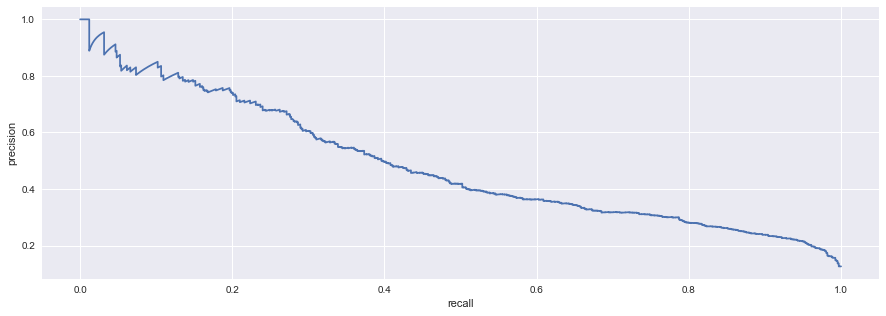

In [1666]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_score_gbm = gbm_best.decision_function(X_test)

precision, recall, threshold = precision_recall_curve(y_test, y_score_gbm)

fig = plt.gcf()
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
fig.set_size_inches((15, 5))
plt.show()

### Implement Feature Selection using SelectFromModel

In [1667]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(gbm_best).fit(X, y)

sfm.transform(X).shape

(21173, 24)

##### We see above that we narrowed the features from 67 features to 22 features. Lets apply the model to try and predict using only 17 features.

In [1668]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

anova_filter = SelectKBest(f_regression, k=36).fit(X_train, y_train)
anova_indices = anova_filter.get_support(indices=True)
anova_features = [X.columns[i] for i in anova_indices]

print pd.Series(anova_features)

#steps = [('anova', anova_filter), 
#         ('gbm', GradientBoostingClassifier(max_features=25))]

#gbm_pipe = Pipeline(steps).fit(X_train, y_train)
#gbm_pipe



#gbm_pipe.set_params(anova__k=25, gbm__max_features=25).fit(X_train, y_train)
#


#y_pred_pipe = pipe.predict(X_test)
#classification_report(y_test, y_pred_pipe)



0                 created_at_insureds
1                 updated_at_insureds
2               liability_claim_count
3               created_at_households
4               updated_at_households
5                 remember_created_at
6                       property_type
7                          year_built
8                           bathrooms
9               created_at_properties
10              updated_at_properties
11                         foundation
12                         roof_shape
13                          roof_type
14                  construction_type
15                           roof_age
16                             status
17                      burglar_alarm
18               fire_alarm_sprinkler
19              fire_alarm_monitoring
20                  secured_community
21                    water_detection
22                              usage
23         renovation_year_electrical
24           renovation_year_plumbing
25       renovation_year_water_heater
26          

In [1669]:
X_skb = X[anova_features]
len(X_skb.columns)

36

### Implement RandomizedSearchCV on df_skb

In [1670]:
param_grid = {'n_estimators' : range(20,101,10),
              'max_depth' : range(3,16,2), 
              'min_samples_split' : range(200,2100,200),
              'min_samples_leaf' : range(30,70,10),
              'max_features' : range(10, len(X.columns), 10),
              'subsample': np.arange(.6,.9,.05),
              'learning_rate' : np.arange(.001, 1, .05)}



rsskb_gbm = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=param_grid, 
                               n_iter=20, scoring='accuracy', refit=True, cv=5, 
                               n_jobs=-1, random_state=9)

rsskb_gbm.fit(X_train, y_train)
rsskb_gbm

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_features': [10, 20, 30, 40, 50, 60], 'learning_rate': array([0.001, 0.051, 0.101, 0.151, 0.201, 0.251, 0.301, 0.351, 0.401,
       0.451, 0.501, 0.551, 0.601, 0.651, 0.701, 0.751, 0.801, 0.851,
       0.901, 0.951]), 'min_samples_leaf': [30, 40, 50, 60], 'n_estimators': [20...t': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [3, 5, 7, 9, 11

In [1671]:
'Best Params: ', rsskb_gbm.best_params_, 'Best Score: ', rsskb_gbm.best_score_

('Best Params: ',
 {'learning_rate': 0.101,
  'max_depth': 5,
  'max_features': 30,
  'min_samples_leaf': 50,
  'min_samples_split': 400,
  'n_estimators': 80,
  'subsample': 0.8500000000000002},
 'Best Score: ',
 0.8941998866427356)

In [1672]:
rsskb_gbm_best = gbm.set_params(**rsskb_gbm.best_params_).fit(X_train, y_train)

y_pred_rsskb = rsskb_gbm_best.predict(X_test)

In [1673]:
print classification_report(y_pred_rsskb, y_test)
print 'Accuracy: ', accuracy_score(y_pred_rsskb, y_test)
print 'ROC AUC: ', roc_auc_score(y_pred_rsskb, y_test)

             precision    recall  f1-score   support

          0       0.99      0.91      0.95      5027
          1       0.31      0.78      0.45       267

avg / total       0.95      0.90      0.92      5294

Accuracy:  0.9025311673592746
ROC AUC:  0.8458317594353785


### Comparing the above model to the original untuned model, the recall dropped from 70% to 60%, but we can see the the precision went up from 34% to 47%

In [1706]:
importances = zip(X.columns, rsskb_gbm_best.feature_importances_)
importances.sort(key=lambda x: x[1], reverse=True)
importances

[(u'renovation_year_water_heater', 0.16472336911488772),
 ('replacement_cost', 0.05098309363830737),
 (u'renovation_year_electrical', 0.05042217284176165),
 (u'dob', 0.050177169454434525),
 ('updated_at_properties', 0.048108319630999874),
 (u'construction_year', 0.04670420436455337),
 ('area_code', 0.045795867042124405),
 ('updated_at_insureds', 0.0419796878025779),
 (u'fire_alarm_monitoring', 0.038321963068366216),
 (u'secured_community', 0.037196137573771354),
 (u'burglar_alarm', 0.031956116133369974),
 (u'sale_price', 0.03143890511813679),
 ('created_at_households', 0.028838462471903088),
 ('updated_at_households', 0.02819490976528597),
 (u'renovation_year_heating', 0.024697186391054508),
 (u'underwriting_confirmed', 0.02397559894603485),
 (u'renovation_year_plumbing', 0.021260419154488876),
 ('created_at_insureds', 0.019961044135820616),
 (u'garage_cars', 0.01889382282174657),
 ('created_at_properties', 0.018386624966736303),
 (u'bathrooms', 0.016655236692071727),
 ('year_built', 0

In [1675]:
pd.concat([pd.DataFrame(y_pred_rsskb, columns=['Predictions'], index=y_test.index), y_test], axis=1) # Test predictions

,Predictions,bound_at
6924,0,0
11362,0,1
2227,0,0
12478,0,0
6958,0,0
7459,0,0
13699,1,1
11259,0,1
14472,0,1
888,0,0


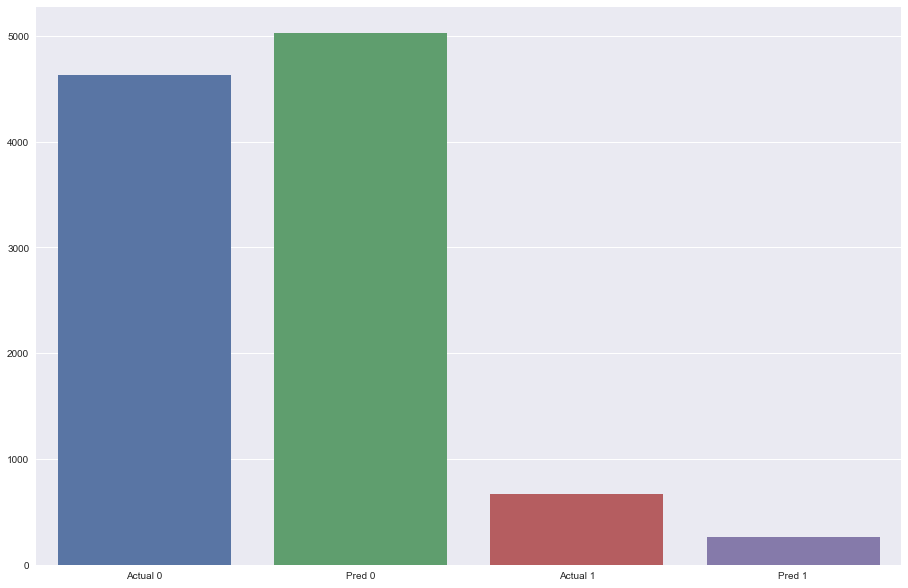

In [1676]:
import seaborn as sns

df['bound_at'].value_counts()
pd.Series(gbm_best_pred).value_counts()



sns.barplot(x=['Actual 0', 'Pred 0', 'Actual 1', 'Pred 1'], 
            y=[y_test.value_counts()[0], pd.Series(y_pred_rsskb).value_counts()[0],
               y_test.value_counts()[1], pd.Series(y_pred_rsskb).value_counts()[1]])
sns.set(rc={'figure.figsize':(15.5, 10.27)})

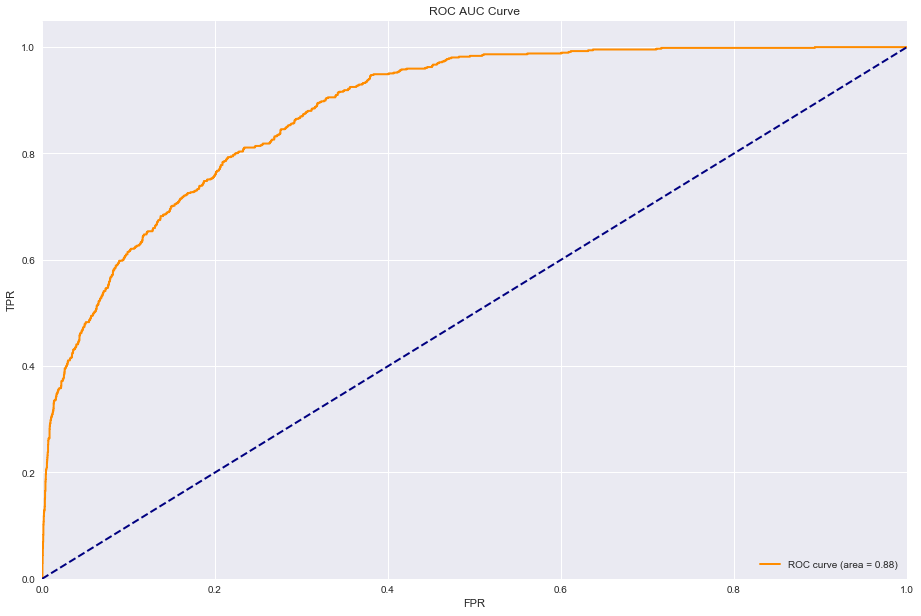

In [1677]:
from sklearn.metrics import roc_curve, auc

y_score = rsskb_gbm_best.decision_function(X_test)



fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [1678]:
print X_normalized.shape

(20926, 63)


In [1679]:
df.loc[df['co_applicant']==False].head()

,email,dob,co_applicant,created_at_insureds,updated_at_insureds,liability_claim_count,non_liability_non_cat_claim_count,fire_loss_count,theft_loss_count,wind_loss_count,...,foundation_percentage,garage_cars,garage_style,pool_value,half_bathrooms,full_bathrooms,one_and_a_half_bathrooms,detached_structures_value,age,area_code
0,-1,362,False,3,1,-1.0,-1.0,0,0,0,...,100.0,-1,-1,0,-1.0,3.0,-1.0,208,6,265
1,-1,298,False,3,1,-1.0,-1.0,0,0,0,...,100.0,2,0,0,-1.0,2.0,-1.0,0,7,113
2,-1,699,False,3,1,-1.0,-1.0,0,0,0,...,100.0,2,0,0,-1.0,2.0,-1.0,0,3,102
3,-1,661,False,3,1,-1.0,-1.0,0,0,0,...,100.0,0,0,0,-1.0,1.0,-1.0,0,4,284
4,-1,713,False,3,1,-1.0,-1.0,0,0,0,...,100.0,2,0,0,-1.0,1.0,-1.0,0,3,307


In [1680]:
len(df)

21173

In [1681]:
rsskb_gbm_best.feature_importances_

array([0.00000000e+00, 5.01771695e-02, 0.00000000e+00, 1.99610441e-02,
       4.19796878e-02, 0.00000000e+00, 7.26708269e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.30378725e-03, 9.78002001e-04,
       0.00000000e+00, 2.88384625e-02, 2.81949098e-02, 1.28508136e-02,
       4.23891856e-05, 3.14389051e-02, 1.60270155e-02, 1.66552367e-02,
       1.83866250e-02, 4.81083196e-02, 2.89073963e-03, 1.68008797e-03,
       9.93767917e-03, 1.26921387e-02, 7.30676294e-03, 8.13673849e-03,
       1.37281743e-02, 5.09830936e-02, 3.19561161e-02, 8.37025933e-03,
       3.83219631e-02, 3.71961376e-02, 1.40997199e-02, 0.00000000e+00,
       1.24248510e-02, 0.00000000e+00, 1.01606020e-03, 5.04221728e-02,
       2.12604192e-02, 1.64723369e-01, 2.46971864e-02, 2.39755989e-02,
       0.00000000e+00, 4.67042044e-02, 8.81839989e-03, 0.00000000e+00,
       1.03760247e-03, 2.04595384e-03, 1.12273601e-03, 8.16799735e-03,
       1.78585265e-03, 0.00000000e+00, 1.88938228e-02, 1.67931760e-03,
      

### Binarize the predict_proba to add more importance to recall than precision 

### Test the model on new data

In [1686]:
len(df_test)

539

In [1698]:
len(df.iloc[len(df) - len(df_test) : len(df)+1])

539

In [1703]:
X_unseen = df.iloc[len(df)-len(df_test) : len(df)+1]
y_unseen = df['bound_at'].iloc[len(df)-len(df_test) : len(df)+1]

In [1707]:
possible_features = [val for val in X.columns if val in X_unseen.columns]
possible_features

[u'email',
 u'dob',
 u'co_applicant',
 'created_at_insureds',
 'updated_at_insureds',
 u'liability_claim_count',
 u'non_liability_non_cat_claim_count',
 u'fire_loss_count',
 u'theft_loss_count',
 u'wind_loss_count',
 u'water_loss_count',
 u'other_loss_count',
 u'married',
 'created_at_households',
 'updated_at_households',
 u'remember_created_at',
 u'property_type',
 u'sale_price',
 'year_built',
 u'bathrooms',
 'created_at_properties',
 'updated_at_properties',
 u'foundation',
 u'roof_shape',
 u'protection_class',
 u'roof_type',
 u'construction_type',
 u'roof_age',
 'status',
 'replacement_cost',
 u'burglar_alarm',
 u'fire_alarm_sprinkler',
 u'fire_alarm_monitoring',
 u'secured_community',
 u'water_detection',
 u'builder',
 'usage',
 u'children_present',
 u'pool',
 u'renovation_year_electrical',
 u'renovation_year_plumbing',
 u'renovation_year_water_heater',
 u'renovation_year_heating',
 u'underwriting_confirmed',
 u'success',
 u'construction_year',
 u'roof_cover_code',
 u'units_in_bu

In [1711]:
unseen_predictions = rsskb_gbm_best.predict(X_unseen[possible_features])

print 'Accuracy: ', accuracy_score(y_unseen, unseen_predictions)
print classification_report(y_unseen, unseen_predictions)

Accuracy:  0.8719851576994434
             precision    recall  f1-score   support

          0       0.89      0.96      0.93       446
          1       0.71      0.43      0.54        93

avg / total       0.86      0.87      0.86       539



In [1714]:
unseen_predictions_df = pd.concat([pd.DataFrame(unseen_predictions, columns=['Predictions'], index=X_unseen.index), y_unseen], axis=1) # Test predictions

unseen_predictions_df


,Predictions,bound_at
21517,0,0
21518,0,1
21519,0,0
21520,0,0
21521,0,0
21522,0,0
21523,0,0
21524,0,0
21525,0,0
21526,0,0


In [1716]:
unseen_predictions_df.to_csv('/Users/mattelgazar/Desktop/unseen_predictions.csv')

In [1719]:
pd.Series(unseen_predictions).value_counts()

0    483
1     56
dtype: int64

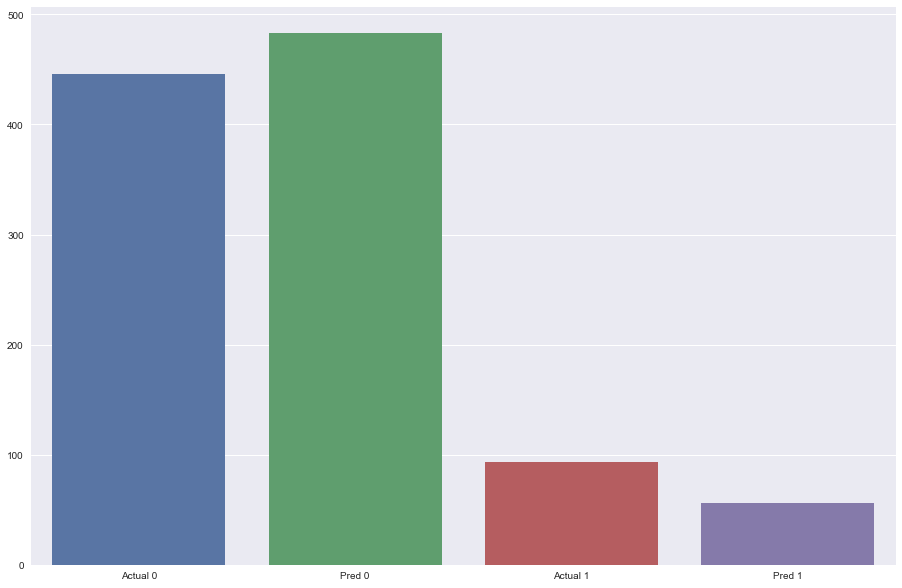

In [1720]:
sns.barplot(x=['Actual 0', 'Pred 0', 'Actual 1', 'Pred 1'], 
            y=[y_unseen.value_counts()[0], pd.Series(unseen_predictions).value_counts()[0],
               y_unseen.value_counts()[1], pd.Series(unseen_predictions).value_counts()[1]])
sns.set(rc={'figure.figsize':(15.5, 10.27)})

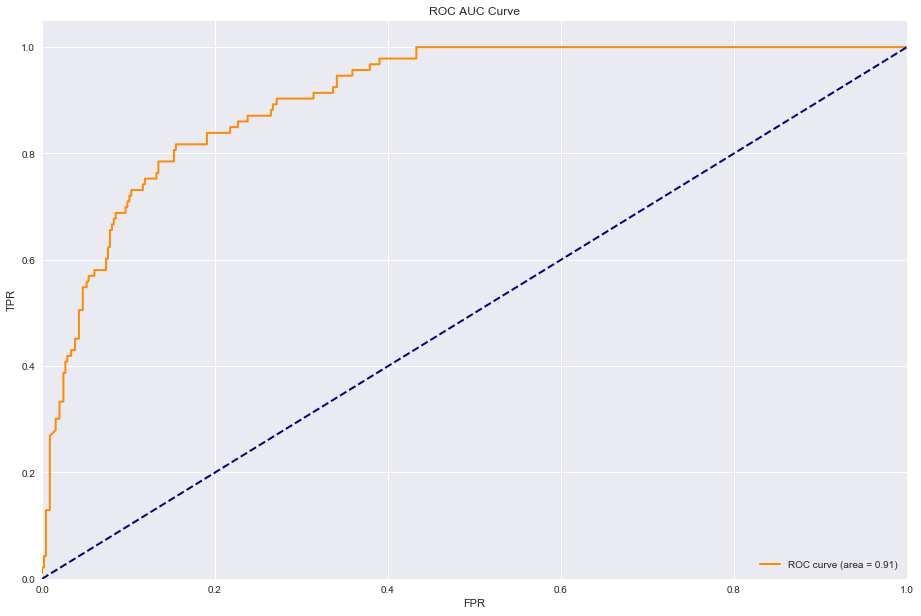

In [1726]:
y_score_unseen = rsskb_gbm_best.decision_function(X_unseen[possible_features])

fpr, tpr, threshold = roc_curve(y_unseen, y_score_unseen)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()